In [6]:
# ===================== Buy/Hold/Sell Analyzer using Massive RESTClient + LangGraph =====================
from __future__ import annotations
import os, math, datetime as dt
from typing import List, Dict, Any, Optional

from dotenv import load_dotenv, find_dotenv
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
# Massive (formerly Polygon) Python SDK
from massive import RESTClient
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
# LangChain / LangGraph (tool-calling)
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool           # <— replaces StructuredTool
from langchain_core.messages import SystemMessage

from langgraph.checkpoint.memory import MemorySaver


# -------------------- ENV / CLIENT --------------------
load_dotenv(find_dotenv(usecwd=True))
API_KEY = os.getenv("MASSIVE_API_KEY")
if not API_KEY:
    raise RuntimeError("Add MASSIVE_API_KEY to your .env")

CLIENT = RESTClient(API_KEY)  # single shared client
os.environ["OPENAI_API_KEY"]=os.getenv("OpenAI_API_KEY")

# -------------------- DATE HELPERS --------------------
def _utc_today() -> dt.date:
    try:
        return dt.datetime.now(dt.UTC).date()              # Py 3.11+
    except AttributeError:
        return dt.datetime.now(dt.timezone.utc).date()     # Py ≤3.10

def _iso(d: dt.date) -> str:
    return d.isoformat()

def _default_window_years(years=3) -> tuple[str, str]:
    end = _utc_today()
    start = end.replace(year=end.year - years)
    return _iso(start), _iso(end)

def _default_news_window() -> tuple[str, str]:
    return _default_window_years(3)


# -------------------- SMALL NUMPY-FREE INDICATORS --------------------
def _series_close(prices: List[Dict[str, Any]]) -> List[float]:
    return [p["close"] for p in prices if p.get("close") is not None]

def _returns(x: List[float], lag: int) -> Optional[float]:
    if len(x) <= lag or x[-(lag+1)] == 0:
        return None
    return x[-1] / x[-(lag+1)] - 1.0

def _rsi_14(x: List[float]) -> Optional[float]:
    if len(x) < 15:
        return None
    gains = losses = 0.0
    for i in range(1, 15):
        ch = x[-i] - x[-i-1]
        gains += max(ch, 0)
        losses += max(-ch, 0)
    if gains == 0 and losses == 0:
        return 50.0
    rs = gains / (losses if losses > 0 else 1e-12)
    return 100 - (100 / (1 + rs))

def _vol_ann(x: List[float]) -> Optional[float]:
    if len(x) < 2:
        return None
    rets = [(x[i] / x[i-1] - 1) for i in range(1, len(x)) if x[i] and x[i-1]]
    if not rets:
        return None
    mean = sum(rets) / len(rets)
    var = sum((r - mean) ** 2 for r in rets) / max(1, len(rets) - 1)
    return (var ** 0.5) * (252 ** 0.5)

def _max_dd(x: List[float]) -> Optional[float]:
    if not x:
        return None
    peak = -1e18
    mdd = 0.0
    for v in x:
        peak = max(peak, v)
        mdd = min(mdd, v / peak - 1.0)
    return mdd

def _default_window_3y() -> tuple[str, str]:
    """
    Default window for price_history: last 3 years [start_date, end_date] as ISO strings.
    """
    try:
        # Py 3.11+
        today = dt.datetime.now(dt.UTC).date()
    except AttributeError:
        # Older Python: use timezone.utc
        today = dt.datetime.now(dt.timezone.utc).date()

    start = today.replace(year=today.year - 3)
    return start.isoformat(), today.isoformat()
# -------------------- RAW DATA TOOLS (Massive client) --------------------

@tool("price_history")
def price_history(
    ticker: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    limit: int = 120,
) -> Dict[str, Any]:
    """
    Fetch daily aggregate price history for a ticker using Massive's list_aggs.

    Args:
        ticker: Equity ticker symbol, e.g. "AAPL".
        start_date: YYYY-MM-DD; if None, defaults to 3 years ago.
        end_date: YYYY-MM-DD; if None, defaults to today.
        limit: Max number of bars to return (Massive requires an int or str).

    Returns:
        {
          "ticker": "AAPL",
          "range": {"start": "...", "end": "..."},
          "prices": [
            {
              "date": "2023-01-09",
              "open": 130.47,
              "high": 133.51,
              "low": 129.89,
              "close": 131.25,
              "volume": 123456789
            },
            ...
          ]
        }
    """
    # Default window if not provided
    if not (start_date and end_date):
        start_date, end_date = _default_window_3y()

    prices: List[Dict[str, Any]] = []

    # This matches your sample:
    # client.list_aggs("AAPL", 1, "day", "2023-01-09", "2023-02-10", adjusted="true", sort="asc", limit=120)
    aggs_iter = CLIENT.list_aggs(
        ticker.upper(),
        1,
        "day",
        start_date,
        end_date,
        adjusted="true",
        sort="asc",
        limit=limit,
    )

    for a in aggs_iter or []:
        # Massive returns model objects; normalize to dict-like
        if hasattr(a, "model_dump"):
            d = a.model_dump()
        elif hasattr(a, "__dict__"):
            d = {k: v for k, v in vars(a).items() if not k.startswith("_")}
        else:
            # If we really can't interpret it, skip this bar
            continue

        # Try both polygon-style and verbose names, just in case
        ts   = d.get("timestamp") or d.get("t")
        o    = d.get("open") or d.get("o")
        h    = d.get("high") or d.get("h")
        l    = d.get("low") or d.get("l")
        c    = d.get("close") or d.get("c")
        vol  = d.get("volume") or d.get("v")

        if ts is not None:
            date_str = dt.datetime.utcfromtimestamp(int(ts) / 1000).date().isoformat()
        else:
            date_str = None

        prices.append(
            {
                "date": date_str,
                "open": o,
                "high": h,
                "low": l,
                "close": c,
                "volume": vol,
            }
        )

    return {
        "ticker": ticker.upper(),
        "range": {"start": start_date, "end": end_date},
        "prices": prices,
    }



@tool("financials")
def financials(
    ticker: str,
    limit: int = 10,
    order: str = "desc",
) -> Dict[str, Any]:
    """
    Fetch stock financials for a ticker using Massive's vx.list_stock_financials.

    Args:
        ticker: Equity ticker symbol, e.g. "AAPL".
        limit: Max number of financial snapshots to pull (as recent or as old as `order` dictates).
        order: "asc" or "desc" on the sort field (we use filing_date).

    Returns:
        {
          "ticker": "AAPL",
          "financials": [ {...}, {...}, ... ]  # raw snapshots as dicts
        }
    """
    snapshots: List[Dict[str, Any]] = []

    fin_iter = CLIENT.vx.list_stock_financials(
        ticker=ticker.upper(),
        order=order,           # "asc" or "desc"
        limit=str(limit),      # Massive expects strings for numeric params
        sort="filing_date",    # you used this in your sample
    )

    for f in fin_iter or []:
        # Massive returns model objects; convert safely to dict
        if hasattr(f, "model_dump"):
            d = f.model_dump()
        elif hasattr(f, "__dict__"):
            d = {k: v for k, v in vars(f).items() if not k.startswith("_")}
        else:
            d = {"raw": str(f)}

        snapshots.append(d)

    return {
        "ticker": ticker.upper(),
        "financials": snapshots,
    }


@tool("sma_indicator")
def sma_indicator(ticker: str, window: int = 50, limit: int = 10) -> Dict[str, Any]:
    """
    Fetch SMA (Simple Moving Average) for a ticker using Massive's indicator endpoint.

    Massive returns model objects, not dicts, so we extract attributes explicitly.
    """
    # Call Massive
    sma_list = CLIENT.get_sma(
        ticker=ticker.upper(),
        timespan="day",
        adjusted=True,
        window=str(window),
        series_type="close",
        order="desc",
        limit=str(limit),
    )

    series: List[Dict[str, Any]] = []

    for p in sma_list or []:
        # Massive SMA objects expose attributes like:
        # p.timestamp  (UNIX ms)
        # p.value      (float)
        
        ts = getattr(p, "timestamp", None)
        val = getattr(p, "value", None)

        # Convert timestamp -> YYYY-MM-DD
        if ts:
            date_str = dt.datetime.utcfromtimestamp(int(ts) / 1000).date().isoformat()
        else:
            date_str = None

        series.append({
            "date": date_str,
            "sma": val,
        })

    return {
        "ticker": ticker.upper(),
        "window": window,
        "series": series,
    }

from typing import Dict, Any, List
from langchain_core.tools import tool

@tool("news")
def news(ticker: str, limit: int = 5, order: str = "desc") -> Dict[str, Any]:
    """
    Fetch recent news via Massive for a given ticker.

    Massive's list_ticker_news does NOT support date ranges, only sorting and limit.
    Returns the latest `limit` articles sorted by published_utc.

    Args:
        ticker: Equity ticker symbol, e.g. "AAPL".
        limit: Max number of news items to fetch.
        order: "asc" or "desc" by published_utc.
    """
    items: List[Dict[str, Any]] = []

    news_iter = CLIENT.list_ticker_news(
        # If your Massive version does NOT support ticker filtering, remove this arg:
        ticker=ticker.upper(),
        order=order,
        limit=str(limit),
        sort="published_utc",
    )

    for n in news_iter or []:
        # Try to be robust: Massive’s model may have article_url or url
        url = getattr(n, "article_url", None) or getattr(n, "url", None)
        source = getattr(n, "publisher", None) or getattr(n, "source", None)
        title = getattr(n, "title", None)
        insights = getattr(n, "insights", None)
        keywords = getattr(n, "keywords", None)
        published_utc = getattr(n, "published_utc", None)

        items.append(
            {
                "title": title,
                "published_utc": str(published_utc),
                "url": url,
                "source": source,
                "keywords": keywords,
                "insights": insights,
            }
        )

        if len(items) >= limit:
            break

    return {
        "ticker": ticker.upper(),
        "items": items,
    }
@tool("sma_indicator")
def sma_indicator(ticker: str, window: int = 50, limit: int = 10) -> Dict[str, Any]:
    """
    Fetch SMA (Simple Moving Average) for a ticker using Massive's indicator endpoint.

    Massive returns model objects, not dicts, so we extract attributes explicitly.
    """
    # Call Massive
    sma_list = CLIENT.get_sma(
        ticker=ticker.upper(),
        timespan="day",
        adjusted=True,
        window=str(window),
        series_type="close",
        order="desc",
        limit=str(limit),
    )

    series: List[Dict[str, Any]] = []

    for p in sma_list or []:
        # Massive SMA objects expose attributes like:
        # p.timestamp  (UNIX ms)
        # p.value      (float)
        
        ts = getattr(p, "timestamp", None)
        val = getattr(p, "value", None)

        # Convert timestamp -> YYYY-MM-DD
        if ts:
            date_str = dt.datetime.utcfromtimestamp(int(ts) / 1000).date().isoformat()
        else:
            date_str = None

        series.append({
            "date": date_str,
            "sma": val,
        })

    return {
        "ticker": ticker.upper(),
        "window": window,
        "series": series,
    }
@tool("short_interest")
def short_interest(
    ticker: str,
    settlement_date: str = "2025-10-31",
    limit: int = 10,
    sort: str = "ticker.asc",
) -> Dict[str, Any]:
    """
    Fetch short interest data for a ticker using Massive's list_short_interest.

    Args:
        ticker: Equity ticker symbol, e.g. "AAPL".
        settlement_date: Settlement date in YYYY-MM-DD format. If None, Massive
                         will return the latest available records (depending on API).
        limit: Max number of records to return.
        sort: Sort expression, e.g. "ticker.asc" or "settlement_date.desc".

    Returns:
        {
          "ticker": "AAPL",
          "results": [
            {
              "settlement_date": "2025-10-31",
              "ticker": "AAPL",
              "short_interest": 115557836,
              "avg_daily_volume": 52555048,
              "days_to_cover": 2.2
            },
            ...
          ]
        }
    """
    results: List[Dict[str, Any]] = []

    kwargs: Dict[str, Any] = {
        "ticker": ticker.upper(),
        "limit": limit,
        "sort": sort,
    }
    # Only include settlement_date if user provided one
    if settlement_date:
        kwargs["settlement_date"] = settlement_date

    si_iter = CLIENT.list_short_interest(**kwargs)

    for item in si_iter or []:
        # Massive returns model objects; normalize to dict
        if hasattr(item, "model_dump"):
            d = item.model_dump()
        elif hasattr(item, "__dict__"):
            d = {k: v for k, v in vars(item).items() if not k.startswith("_")}
        else:
            # fallback if it's already a dict-like
            try:
                d = dict(item)
            except Exception:
                d = {"raw": str(item)}

        results.append(
            {
                "settlement_date": d.get("settlement_date"),
                "ticker": d.get("ticker"),
                "short_interest": d.get("short_interest"),
                "avg_daily_volume": d.get("avg_daily_volume"),
                "days_to_cover": d.get("days_to_cover"),
            }
        )

        if len(results) >= limit:
            break

    return {
        "ticker": ticker.upper(),
        "results": results,
    }
def _short_interest_features(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Use the most recent short interest record to compute a couple of features.
    """
    if not results:
        return {"days_to_cover": None, "si_to_volume": None}

    latest = results[0]
    si = latest.get("short_interest")
    adv = latest.get("avg_daily_volume")
    days_to_cover = latest.get("days_to_cover")

    si_to_volume = (si / adv) if (si and adv and adv != 0) else None
    return {
        "days_to_cover": days_to_cover,
        "si_to_volume": si_to_volume,
    }
def _simple_fin_features(fin_list: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Take Massive vx.list_stock_financials snapshots (already dicts) and
    try to pull a few basic values: revenue, net_income, ebitda, assets, debt, cash.
    We look into nested structures in a best-effort way.
    """
    if not fin_list:
        return {
            "revenue": None,
            "net_income": None,
            "ebitda": None,
            "assets": None,
            "debt": None,
            "cash": None,
            "net_margin": None,
            "leverage": None,
        }

    # Use the most recent snapshot (assuming order="desc" → freshest first)
    f = fin_list[0]

    def _find_number(d: Any, candidates: List[str]) -> Optional[float]:
        """Best-effort search in nested dicts for a numeric value."""
        if not isinstance(d, dict):
            return None
        # direct keys
        for k in candidates:
            if k in d and isinstance(d[k], (int, float)):
                return d[k]
        # nested dicts
        for v in d.values():
            if isinstance(v, dict):
                res = _find_number(v, candidates)
                if res is not None:
                    return res
        return None

    revenue    = _find_number(f, ["revenue", "revenues", "total_revenue"])
    net_income = _find_number(f, ["net_income", "income", "net_income_loss"])
    ebitda     = _find_number(f, ["ebitda", "EBITDA"])
    assets     = _find_number(f, ["assets", "total_assets"])
    debt       = _find_number(f, ["debt", "total_debt", "long_term_debt"])
    cash       = _find_number(f, ["cash", "cash_and_equivalents"])

    net_margin = (net_income / revenue) if (revenue and net_income) else None
    leverage   = (debt / assets) if (debt and assets) else None

    return {
        "revenue": revenue,
        "net_income": net_income,
        "ebitda": ebitda,
        "assets": assets,
        "debt": debt,
        "cash": cash,
        "net_margin": net_margin,
        "leverage": leverage,
    }
def _news_sentiment(items: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Very simple keyword-based sentiment proxy from news titles.

    Returns a dict with:
      - news_pos: count of positive headlines
      - news_neg: count of negative headlines
      - sentiment: (pos - neg) / max(1, pos + neg)
    """
    pos_kw = ("beats", "surge", "record", "raise", "growth", "upgraded", "profit", "strong")
    neg_kw = ("miss", "falls", "cuts", "downgrade", "guidance cut", "probe", "lawsuit", "loss", "weak")

    pos = neg = 0
    for n in items[:50]:  # cap at 50 headlines
        title = (n.get("title") or "").lower()
        if any(k in title for k in pos_kw):
            pos += 1
        if any(k in title for k in neg_kw):
            neg += 1

    total = max(1, pos + neg)
    sentiment = (pos - neg) / total

    return {
        "news_pos": pos,
        "news_neg": neg,
        "sentiment": sentiment,
    }
def _norm(x: Optional[float], lo: float, hi: float) -> float:
    """
    Normalize a numeric value into a 0–100 score between [lo, hi].
    If x is None or lo==hi, return neutral 50.
    """
    if x is None:
        return 50.0
    if hi == lo:
        return 50.0
    z = (x - lo) / (hi - lo)
    return max(0.0, min(100.0, 100 * z))


def _pillars(
    tech: Dict[str, Any],
    fin: Dict[str, Any],
    newsf: Dict[str, Any],
    shortf: Dict[str, Any],
) -> Dict[str, float]:
    """
    Combine technicals, fundamentals, news sentiment, and short interest
    into five pillar scores on a 0–100 scale:
    - trend
    - risk
    - quality
    - valuation
    - events
    """

    # --- Trend: returns + price vs 200-day ---
    trend = (
        0.25 * _norm(tech.get("ret_3m"),  -0.20, 0.20) +
        0.25 * _norm(tech.get("ret_6m"),  -0.40, 0.40) +
        0.25 * _norm(tech.get("ret_12m"), -0.80, 0.80) +
        0.25 * _norm(tech.get("px_vs_200"), -0.30, 0.30)
    )

    # --- Risk: volatility + max drawdown + days_to_cover ---
    vol_score = 100 - _norm(tech.get("vol_ann"), 0.10, 0.80)
    dd_score  = 100 - _norm(abs(tech.get("max_dd") or 0), 0.10, 0.70)
    dtc_score = 100 - _norm(shortf.get("days_to_cover"), 0.0, 10.0)  # more days_to_cover => more risk

    risk = 0.4 * vol_score + 0.4 * dd_score + 0.2 * dtc_score

    # --- Quality: profitability + leverage ---
    quality = 0.6 * _norm(fin.get("net_margin"), 0.00, 0.25) \
              + 0.4 * (100 - _norm(fin.get("leverage"), 0.00, 1.00))

    # --- Valuation: placeholder for now (neutral) ---
    valuation = 50.0
    # later you can plug EV/EBITDA or P/E into _norm and set a real valuation score.

    # --- Events: news sentiment + short-interest pressure ---
    sentiment_score = _norm(newsf.get("sentiment"), -1.0, 1.0)
    si_score = 100 - _norm(shortf.get("si_to_volume"), 0.0, 0.5)  # high short/volume = more risk

    events = 0.7 * sentiment_score + 0.3 * si_score

    return {
        "trend": trend,
        "risk": risk,
        "quality": quality,
        "valuation": valuation,
        "events": events,
    }
def _decide(p: Dict[str, float]) -> Dict[str, Any]:
    """
    Turn pillar scores into an overall score and a Buy/Hold/Sell label.

    We weight pillars like this:
      - trend:     30%
      - risk:      15%
      - quality:   25%
      - valuation: 20%
      - events:    10%

    Thresholds:
      - score >= 70  -> "Buy"
      - 45 <= score < 70 -> "Hold"
      - score < 45   -> "Sell"
    """
    score = (
        0.30 * p.get("trend", 50.0) +
        0.15 * p.get("risk", 50.0) +
        0.25 * p.get("quality", 50.0) +
        0.20 * p.get("valuation", 50.0) +
        0.10 * p.get("events", 50.0)
    )

    if score >= 70:
        label = "Buy"
    elif score >= 45:
        label = "Hold"
    else:
        label = "Sell"

    return {
        "label": label,
        "score": round(score, 1),
    }

# -------------------- ANALYZE TOOL (end-to-end) --------------------
@tool("analyze_stock")
def analyze_stock(
    ticker: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
) -> Dict[str, Any]:
    """
    End-to-end Buy/Hold/Sell analysis using Massive-based tools:
    - price_history
    - financials
    - news
    - short_interest
    """
    # 1) Price history (let the tool apply its own default window if dates omitted)
    ph_args: Dict[str, Any] = {"ticker": ticker}
    if start_date:
        ph_args["start_date"] = start_date
    if end_date:
        ph_args["end_date"] = end_date
    ph = price_history.invoke(ph_args)

    closes = _series_close(ph["prices"])

    # Simple SMA-200 from closes (we don't *need* sma_indicator here)
    sma200 = (sum(closes[-200:]) / 200) if len(closes) >= 200 else None

    tech = {
        "ret_1m":  _returns(closes, 21),
        "ret_3m":  _returns(closes, 63),
        "ret_6m":  _returns(closes, 126),
        "ret_12m": _returns(closes, 252),
        "rsi14":   _rsi_14(closes),
        "vol_ann": _vol_ann(closes),
        "max_dd":  _max_dd(closes),
        "px_vs_200": (closes[-1] / sma200 - 1.0) if (sma200 and closes) else None,
    }

    # 2) Financials
    fin_raw = financials.invoke({"ticker": ticker})
    finf = _simple_fin_features(fin_raw.get("financials", []))

    # 3) News
    nws = news.invoke({"ticker": ticker, "limit": 30, "order": "desc"})
    newsf = _news_sentiment(nws.get("items", []))

    # 4) Short interest
    si = short_interest.invoke({"ticker": ticker, "limit": 5})
    shortf = _short_interest_features(si.get("results", []))

    # 5) Pillars & decision
    pillars = _pillars(tech, finf, newsf, shortf)
    decision =  (pillars)

    return {
        "ticker": ticker.upper(),
        "range": ph.get("range", {}),
        "decision": decision,
        "pillars": {k: round(v, 1) for k, v in pillars.items()},
        "features": {
            "technical": tech,
            "fundamentals": finf,
            "news": newsf,
            "short_interest": shortf,
        },
        "raw": {
            "price_history_points": len(ph.get("prices", [])),
            "financial_snapshots": len(fin_raw.get("financials", [])),
            "news_items": len(nws.get("items", [])),
            "short_interest_records": len(si.get("results", [])),
        }
    }


from typing import Dict, Any, List, Optional
from langchain_core.tools import tool
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# Assumes you already did somewhere above:
# from massive import RESTClient
# MASSIVE_API_KEY = os.getenv("MASSIVE_API_KEY")
# CLIENT = RESTClient(MASSIVE_API_KEY)



#


In [3]:
# ===================== LLM + LangGraph wiring =====================
import os
from typing import TypedDict, Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ---------- State definition ----------
class GraphState(TypedDict):
    # LangGraph will append messages here across turns
    messages: Annotated[list[AnyMessage], add_messages]

# ---------- Tools list ----------
# Make sure these names exist above (your @tool functions)
tools = [
    price_history,
    financials,
    sma_indicator,
    news,
    short_interest,
    analyze_stock,
]

# ---------- System prompt ----------
SYSTEM = SystemMessage(content="""
You are a stock analyst who can CALL TOOLS.

If the user asks to analyze a stock or wants a recommendation (Buy/Hold/Sell),
call analyze_stock(ticker, start_date?, end_date?).

If the user asks for raw data:
- price history  -> price_history
- financials     -> financials
- news           -> news
- short interest -> short_interest
- SMA            -> sma_indicator

When giving a recommendation, ALWAYS include:
- Buy/Hold/Sell label and overall score
- Pillar scores (trend, risk, quality, valuation, events)
- 2–4 concise bullets with concrete metrics
  (e.g. 12M return, volatility, max drawdown, net margin, days_to_cover)
- A short comment on recent news sentiment

Do not invent numbers; use only tool outputs.
""")

# ---------- LLM (tool-calling) ----------
llm = ChatOpenAI(
    model=os.getenv("OPENAI_MODEL", "gpt-4o-mini"),
    temperature=0,
).bind_tools(tools)

# ---------- Assistant node ----------
def assistant(state: GraphState):
    # Prepend system message, then pass conversation so far
    ai = llm.invoke([SYSTEM] + state["messages"])
    return {"messages": [ai]}

# ---------- Graph wiring ----------
g = StateGraph(GraphState)

# Nodes
g.add_node("assistant", assistant)
g.add_node("tools", ToolNode(tools))

# Edges
g.add_edge(START, "assistant")
g.add_conditional_edges("assistant", tools_condition)  # assistant -> tools or END
g.add_edge("tools", "assistant")                       # tools -> assistant

# Compile with in-memory checkpointing (thread_id support)
memory = MemorySaver()
graph = g.compile(checkpointer=memory)
# If you don't want persistence while debugging, you can instead do:
# graph = g.compile()


In [4]:
from langchain_core.messages import HumanMessage

cfg = {"configurable": {"thread_id": "massive-analyzer-demo"}}

res = graph.invoke(
    {"messages": [HumanMessage(content="What about nVidia? Should I be worried about the AI bubble impacting the stock?")]},
    config=cfg,
)

print(res["messages"][-1].content)


/var/folders/5k/zr6bml6s6dd_jty1hvzwrv7r0000gn/T/ipykernel_35117/2141762338.py:180: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date_str = dt.datetime.utcfromtimestamp(int(ts) / 1000).date().isoformat()


### Recommendation for NVIDIA (NVDA)
**Overall Score: Hold**

#### Pillar Scores:
- **Trend:** 76.6
- **Risk:** 55.9
- **Quality:** 50.0
- **Valuation:** 50.0
- **Events:** 60.0

#### Key Metrics:
- **12M Return:** 30.5%
- **Max Drawdown:** -36.9%
- **Days to Cover:** 1.35
- **RSI (14):** 35.7 (indicating potential oversold conditions)

#### Recent News Sentiment:
- Positive sentiment with 6 positive news articles and 1 negative, resulting in a sentiment score of approximately 71.4%.

### Comment:
While NVIDIA has shown strong returns over the past year, the stock is currently facing some risk factors, particularly with a max drawdown of nearly 37%. The positive news sentiment suggests that there is still confidence in the company's prospects, but caution is warranted given the potential impact of the AI bubble. Holding may be a prudent strategy until clearer trends emerge.


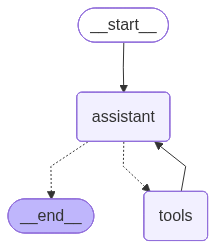

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))